In [2]:
from utils.utils import get_config, get_distribution_dataframe
import os
config_path = 'config/med.yaml'
config = get_config(config_path)
gpu = config['train']['gpu']
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from model import SpecNet, MedTestingNet
from dataset import MedTestingDataset
from train_med import train, predict, test

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

In [4]:
base_dir = config['base']['base_dir']
data_dir = config['base']['data_dir']
batch_size = config['train']['batch_size']
lr = float(config['train']['lr'])
num_epoch = config['train']['epoch']
rate = config['train']['rate']
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [5]:
seed = 10
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [10]:
dataset = MedTestingDataset(os.path.join(data_dir, 'feature', 'feature_seg'))
train_len = int(len(dataset)*rate)
valid_len = int((len(dataset)-train_len)/2)
test_len = len(dataset)-train_len-valid_len
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_len, valid_len, test_len])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print(len(train_dataloader), len(valid_dataloader), len(test_dataloader))


26370 26370
Counter({0: 19880, 1: 6490})
660 83 83


In [6]:
state = torch.load('/mnt/flingroup/maruokai/pd_data/checkpoint/6/best_ckpt.pth')
base_model = SpecNet(out_num=15)
base_model.load_state_dict(state['model'])
model = MedTestingNet(base_model)
# model = MedTestingNet()
criterion = nn.BCELoss()
optimizer = optim.SGD(filter(lambda x:x.requires_grad, model.parameters()), lr=lr, weight_decay=5e-4)
train_loss_history, train_acc_history, valid_loss_history, valid_acc_history = train(model=model, num_epoch=num_epoch, criterion=criterion, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, optimizer=optimizer, device=device, log_interval=20, save_dir=data_dir)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [8]:
state = torch.load('/mnt/flingroup/maruokai/datasets/pd_data/checkpoint/6/best_ckpt.pth')
base_model = SpecNet(out_num=15)
base_model.load_state_dict(state['model'])
model = MedTestingNet(base_model)
state = torch.load('/mnt/DataCenter/maruokai/datasets/pd/checkpoint/3/best_ckpt.pth', map_location=torch.device('cuda'))
model.load_state_dict(state['model'])

<All keys matched successfully>

In [11]:
logits, label = predict(model, test_dataloader, device=device)

In [12]:
len(logits), len(label)

(2637, 2637)

In [13]:
fpr, tpr, thresholds = metrics.roc_curve(y_true=label, y_score=logits)

In [14]:
auc = metrics.auc(fpr, tpr)
auc

0.69473501176737

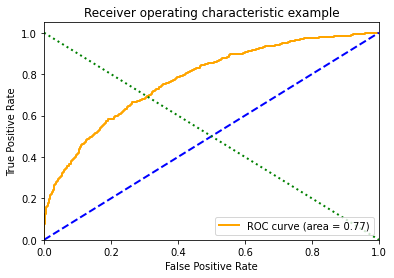

In [ ]:

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='orange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='dashed')
plt.plot([0, 1], [1, 0], color='green', lw=lw, linestyle='dotted')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [ ]:
logits_np = np.array(logits)
logits_np[logits_np>=0.5]

array([0.51278627, 0.7476991 , 0.56339514, 0.603834  , 0.5361272 ,
       0.5528865 , 0.53449064, 0.51898086, 0.9245435 , 0.9130546 ,
       0.5079333 , 0.6539638 , 0.8996746 , 0.64061546, 0.5080933 ,
       0.5300758 , 0.54931486, 0.53322774, 0.76227295, 0.64132607,
       0.5636836 , 0.65182936, 0.6074509 , 0.5675548 , 0.6067951 ,
       0.55826825, 0.5163591 , 0.6803711 , 0.63871676, 0.54116297,
       0.5380465 , 0.972347  , 0.7484066 , 0.63254243, 0.5186659 ,
       0.67909366, 0.8442683 , 0.6122395 , 0.5696504 , 0.54943436,
       0.9000235 , 0.866025  , 0.89891726, 0.54844594, 0.5817849 ,
       0.7880879 , 0.65981776, 0.53478533, 0.5901971 , 0.85241896,
       0.66665196, 0.82267934, 0.51931787, 0.71718544, 0.5324167 ,
       0.5237728 , 0.52210224, 0.55518764, 0.9011064 , 0.655124  ,
       0.8751284 , 0.6105733 , 0.5452182 , 0.63782716, 0.7777654 ,
       0.7118982 , 0.5201422 , 0.94992745, 0.61131346, 0.6648623 ,
       0.5289144 , 0.5023665 , 0.70754004, 0.82456213, 0.72228